In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.neighbors import NearestNeighbors
from sklearn import manifold
import scipy
from scipy.linalg import eigh

# Dataset

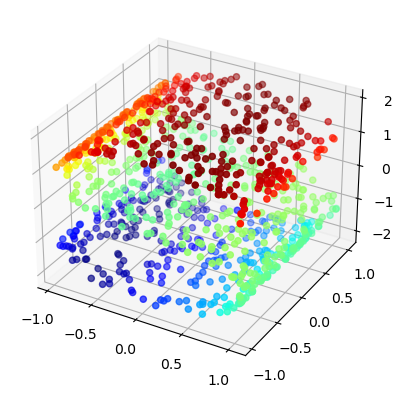

In [3]:
n_samples = 1000
X, _ = ds.make_s_curve(n_samples=n_samples, noise=0)
X = X-X.mean(0)
anchor = np.amin(X,0)
dx = X.shape[1]
coloring = ((X[:,0]-anchor[0])**2 + (X[:,2]-anchor[2])**2)**0.5
coloring = coloring-coloring.min()
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)

# K means

/tmp/ipykernel_9512/1089707551.py:17: RuntimeWarning: Mean of empty slice.
  barycenters = X[indexes==i].mean(axis=0)
/home/tau/emenier/miniconda3/envs/LED/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


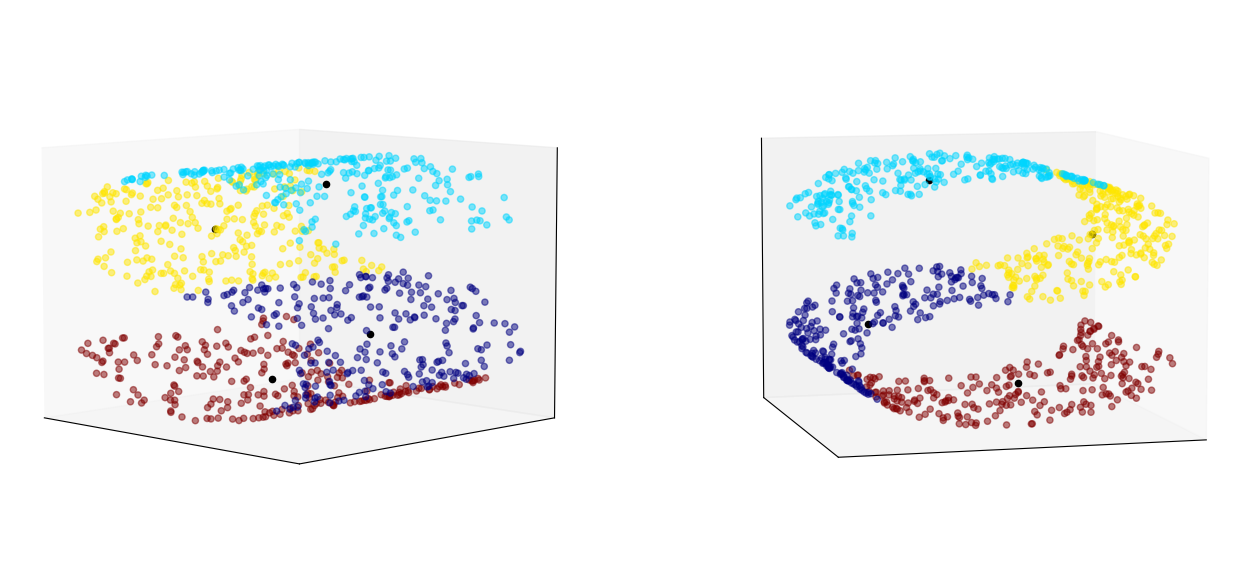

In [4]:
def compute_cluster_indexes(X,centers):
    # computes closest cluster for each point
    distances = [(X-c)**2 for c in centers] # distance to clusters
    distances = np.stack([d.sum(1) for d in distances]).T
    indexes = np.argmin(distances,axis=1) # index of min distance
    return indexes

# Random clusters
n_clusters = 4
centers = 10*np.random.randn(n_clusters*dx).reshape(n_clusters,dx)
diff = np.inf
while diff > 1e-4: 
    indexes = compute_cluster_indexes(X,centers)
    diff = 0
    for i in range(n_clusters):
        # Compute the barycenter
        barycenters = X[indexes==i].mean(axis=0)
        if np.isnan(barycenters).any():
            # New random cluster if barycenter is nan
            centers[i] = np.random.randn(dx)
            diff = np.inf
            pass
        else:
            # Move cluster to barycenter
            diff = max((barycenters-centers[i]).max(),diff)
            centers[i] = barycenters
indexes = compute_cluster_indexes(X,centers)

def plot_one(X,indexes,centers):
    ax.scatter(*X.T,c=indexes,alpha=0.5,cmap=plt.cm.jet)
    for c in centers:
        ax.scatter(*c,color='black')
    ax.set_xticks([]);ax.set_yticks([]);ax.set_zticks([])
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(121,projection='3d', elev=7, azim=-45)
plot_one(X,indexes,centers)
ax = fig.add_subplot(122,projection='3d', elev=7, azim=75)
plot_one(X,indexes,centers)


# PCA

([], [])

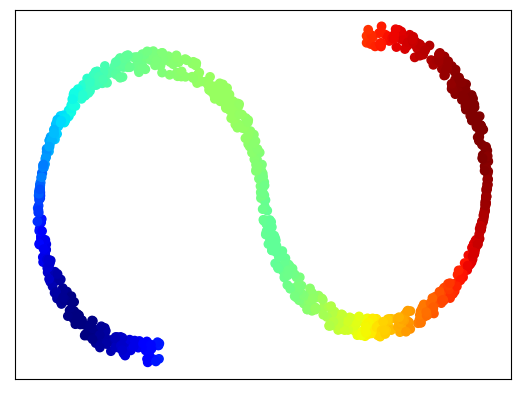

In [5]:
U,s,V = np.linalg.svd(X.T-X.mean(0).reshape(-1,1))
pca = U[:,:2].T.dot(X.T)
plt.scatter(*pca,c=coloring,cmap=plt.cm.jet)
plt.xticks([]);plt.yticks([])

# Diffusion maps
[Tutorial](https://inside.mines.edu/~whereman/talks/delaPorte-Herbst-Hereman-vanderWalt-DiffusionMaps-PRASA2008.pdf)

[Kaggle Example](https://www.kaggle.com/code/rahulrajpl/diffusion-map-for-manifold-learning)

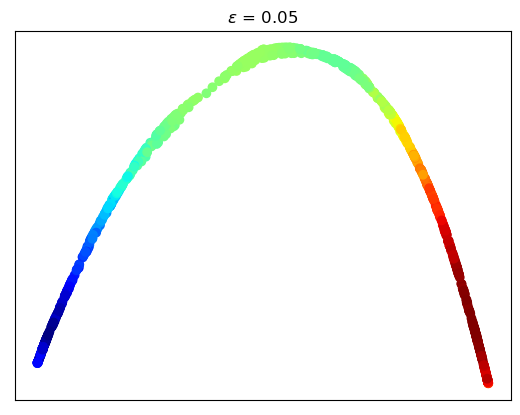

In [6]:
# Distances
dists = euclidean_distances(X,X)
def get_coords(eps):
    # Kernel
    K = np.exp(-dists**2/eps)
    r = K.sum(0)
    D = np.diag(1/r)
    # Probability (Kernel normalisation)
    P = np.matmul(D, K)
    P.sum(1).mean(),P.sum(1).std() 
    
    D_right = np.diag((r)**0.5)
    D_left = np.diag((r)**-0.5)
    P_prime = np.matmul(D_right, np.matmul(P,D_left))
    # Eigendecomposition
    eigvals, V = eigh(P_prime)
    idx = eigvals.argsort()[::-1]
    eigvals = eigvals[idx]
    V = V[:,idx]

    coords = np.matmul(D_left,V)[:,1:3]
    return coords

diffmap = get_coords(0.05)
plt.title(r'$\epsilon$ = {}'.format(0.05))
plt.scatter(*diffmap.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([])
plt.show()

# Locally Linear Embedding
[Tutorial](https://cs.nyu.edu/~roweis/lle/papers/lleintro.pdf)

[Kaggle example](https://www.kaggle.com/code/ukveteran/locally-linear-embedding-swiss-roll-data-jma/notebook)

([], [])

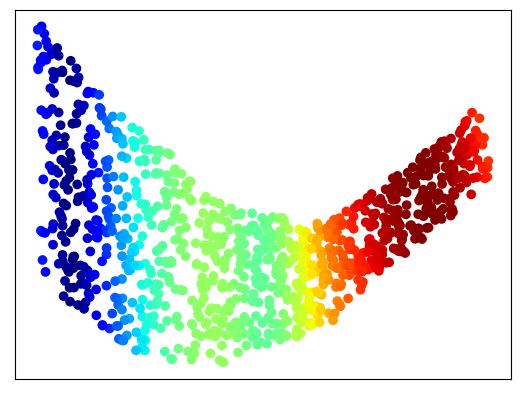

In [7]:
# KNN
n_neighbors = 12
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X)
distance_mat, neighbours_mat = knn.kneighbors(X)
# Local spaces construction
matrices = []
for n in neighbours_mat:
    matrices.append(np.stack([X[i] for i in n]))
matrices=np.stack(matrices)
# Local correlation and weights computation
stacked_X = np.stack([X])
stacked_X = np.moveaxis(stacked_X,0,1)
diff = stacked_X-matrices
W = np.zeros((X.shape[0],X.shape[0]))
for i,(n,dif) in enumerate(zip(neighbours_mat,diff)):
    C = np.matmul(dif,dif.T)
    C = C+np.identity(n_neighbors)*1e-4*np.trace(C)
    c_inv = np.linalg.inv(C)
    W[i][n] = c_inv.sum(1)/c_inv.sum()
# Eigenvectors computation
M = np.matmul((np.eye(X.shape[0])-W).T,(np.eye(X.shape[0])-W))
eigvals, eigvecs = eigh(M)
index = np.argsort(eigvals)
lle = eigvecs[:,index[1:3]]*np.sqrt(X.shape[0])

plt.scatter(*lle.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]);plt.yticks([])

# Isomap

/home/tau/emenier/miniconda3/envs/LED/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


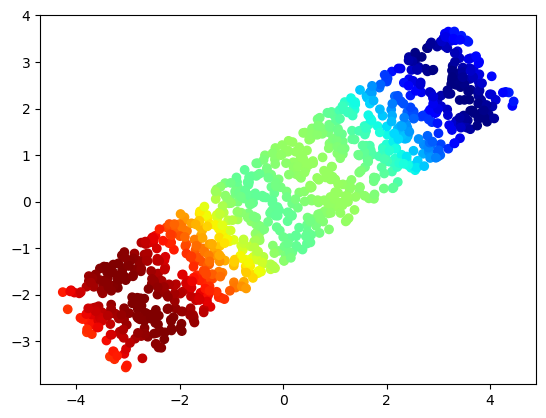

In [8]:
# KNN
n_neighbors = 12
knn = NearestNeighbors(n_neighbors=n_neighbors)
knn.fit(X)
distance_mat, neighbours_mat = knn.kneighbors(X)
# Geodesic distance
graph = np.zeros((X.shape[0],X.shape[0]))
for i,(dist,neighb) in enumerate(zip(distance_mat, neighbours_mat)):
    graph[i][neighb] = dist

distances = scipy.sparse.csgraph.dijkstra(graph,directed=False)
#Stress optimisation (MDS)
isomap,_ = manifold.smacof(distances)

plt.scatter(*isomap.T,c=coloring,cmap=plt.cm.jet)

# Side by Side

In [11]:
arr.shape

(2, 1000)

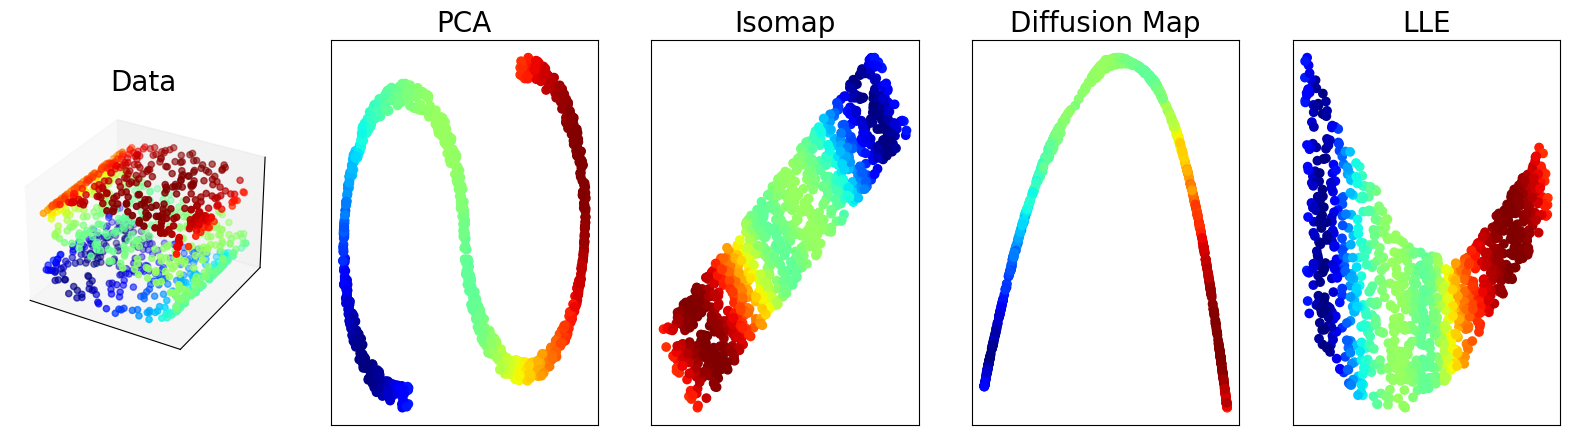

In [13]:
fs = 20
fig = plt.figure(figsize=(20,5))
ax = fig.add_subplot(1,5,1,projection='3d')
ax.scatter(*X.T,c=coloring,cmap=plt.cm.jet)
plt.xticks([]); plt.yticks([]); ax.set_zticks([])
plt.title('Data',fontsize=fs)

arrays = [pca.T,isomap,diffmap,lle]
titles = ['PCA','Isomap','Diffusion Map','LLE']
for i,(arr,titl) in enumerate(zip(arrays,titles)):
    ax = fig.add_subplot(1,5,i+2)
    plt.title(titl,fontsize=fs)
    ax.scatter(*arr.T,c=coloring,cmap=plt.cm.jet)
    plt.xticks([]); plt.yticks([])